In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
import random
import shutil
import pathlib
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def split_dir_to_train_test_val(directory = "/content/drive/MyDrive/triclass/skin_disease/",
                            train_size = 0.7,
                            test_size = 0.2,
                            val_size = 0.1):

  # Set random seed
  rng = random.Random(42)

  for root, folders, files in os.walk(directory):
    for folder in folders:
      # Create list of the files
      list_of_files = []
      for file_name in os.listdir(root+folder+"/"):
        list_of_files.append(file_name)

      #  Shuffle the list
      rng.shuffle(list_of_files)

      # Create lists of files
      train_files = list_of_files[:int(len(list_of_files)*train_size)]
      test_files = list_of_files[int(len(list_of_files)*train_size) : int(len(list_of_files)*(train_size+test_size))]
      val_files = list_of_files[int(len(list_of_files)*(train_size+test_size)):]

      # Create folders and files for train data
      for one_file in train_files:

        # Copy  files
        dest_dir = "files/train/"+folder+"/"
        shutil.copy2(src=(root+folder+"/"+one_file),
                    dst=(dest_dir+one_file))


      # Create folders and files for test data
      for one_file in test_files:
        # Copy  files
        dest_dir = "files/test/"+folder+"/"
        shutil.copy2(src=(root+folder+"/"+one_file),
                    dst=(dest_dir+one_file))


      # Create folders and files for validation data
      for one_file in val_files:

        # Copy  files
        dest_dir = "files/validation/"+folder+"/"
        shutil.copy2(src=(root+folder+"/"+one_file),
                    dst=(dest_dir+one_file))


def get_class(directory):
  data_dir = pathlib.Path(directory)
  class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class names
  return class_names
  print(class_names)

In [ ]:
split_dir_to_train_test_val(directory="/content/drive/MyDrive/triclass/skin_disease/",
                            train_size=0.7,
                            test_size=0.2,
                            val_size=0.1)

In [ ]:
class_names = get_class(directory="files/train/")
class_names

array(['Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions',
       'Atopic Dermatitis Photos', 'Melanoma Skin Cancer Nevi and Moles',
       'Vasculitis Photos', 'Warts Molluscum and other Viral Infections'],
      dtype='<U66')

In [ ]:
len(class_names)

5

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255, rotation_range=45,width_shift_range=0.2, zoom_range = 0.2, horizontal_flip = True, brightness_range = (0.5, 1.5),shear_range = 0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)


train_data = train_datagen.flow_from_directory(directory="files/train/",
                                               target_size=(240, 240),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(directory="files/test/",
                                               target_size=(240, 240),
                                               batch_size=32,
                                               class_mode="categorical")

validation_data = val_datagen.flow_from_directory(directory="files/validation/",
                                               target_size=(240, 240),
                                               batch_size=32,
                                               class_mode="categorical")


In [ ]:
def build_model(hp):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(5, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False


    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Compile the model
    opt = SGD(learning_rate=hp_learning_rate, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Perform hyperparameter tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='random_search',
    project_name='resnet50')

tuner.search(train_data,
             validation_data=validation_data,
             epochs=10,
             batch_size=32)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hyperparameters}")

# Build the best model
best_model = tuner.hypermodel.build(best_hyperparameters)

# Train the best model
history = best_model.fit(train_data,
                         validation_data=validation_data,
                         epochs=100,
                         batch_size=32)


Trial 3 Complete [00h 11m 43s]
val_accuracy: 0.22748814523220062

Best val_accuracy So Far: 0.3127962052822113
Total elapsed time: 00h 35m 18s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7cbf91f118a0>
Epoch 1/100
138/138 [==============================] - 73s 508ms/step - loss: 1.6374 - accuracy: 0.2206 - val_loss: 1.6584 - val_accuracy: 0.2148
Epoch 2/100
138/138 [==============================] - 69s 502ms/step - loss: 1.6389 - accuracy: 0.2113 - val_loss: 1.6001 - val_accuracy: 0.2101
Epoch 3/100
138/138 [==============================] - 69s 502ms/step - loss: 1.6355 - accuracy: 0.2186 - val_loss: 1.6032 - val_accuracy: 0.2259
Epoch 4/100
138/138 [==============================] - 69s 503ms/step - loss: 1.6199 - accuracy: 0.2249 - val_loss: 1.5964 - val_accuracy: 0.2701
Epoch 5/100
138/138 [==============================] - 70s 507ms/step - loss: 1.6140 - accuracy: 0.2362 - val_loss: 1.6106 - val_accuracy: 0.2370
Epoch 6

In [ ]:
best_model.evaluate(test_data)

40/40 [==============================] - 4s 106ms/step - loss: 1.5039 - accuracy: 0.3579


[1.5038771629333496, 0.35787805914878845]

<Axes: >

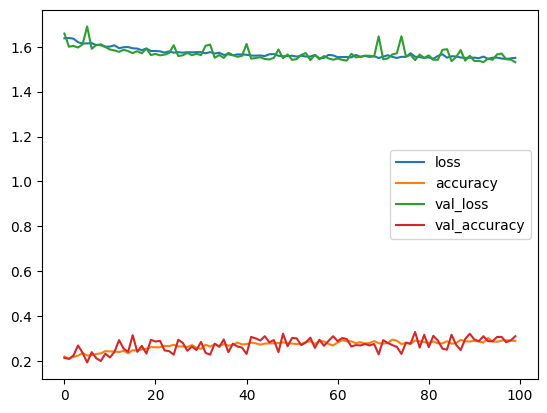

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
best_model.save("resnet50_model.h5")
def load_and_resize_image(filename, size):

  # Load image
  img = tf.io.read_file(filename)

  # Compile image
  img = tf.image.decode_image(img)

  # Resize image
  img = tf.image.resize(img, [size, size])

  # Scale the tensor
  img = img / 255

  return img

image = load_and_resize_image("/content/atrophy-blanche-1.jpg", 224)
pred = best_model.predict(tf.expand_dims(image, axis=0))
pred

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 1s 1s/step


array([[0.16715676, 0.2580917 , 0.11036462, 0.34443903, 0.11994784]],
      dtype=float32)

In [ ]:


true_labels = test_data.classes

# Evaluate the model on the test data
loss, accuracy = best_model.evaluate(test_data)

# Predict labels using the best model
predicted_probs = best_model.predict(test_data)
predicted_labels = np.argmax(predicted_probs, axis=1)  # Convert predicted probabilities to class labels
# Calculate additional metrics
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
cm = confusion_matrix(true_labels, predicted_labels)

mcc = matthews_corrcoef(true_labels, predicted_labels)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("Matthews Correlation Coefficient:", mcc)


40/40 [==============================] - 5s 94ms/step
Test Loss: 1.5039011240005493
Test Accuracy: 0.35787805914878845
Precision: 0.17530371549993717
Recall: 0.21377672209026127
F1 Score: 0.1857480583067488
Matthews Correlation Coefficient: 0.0001000264316619104


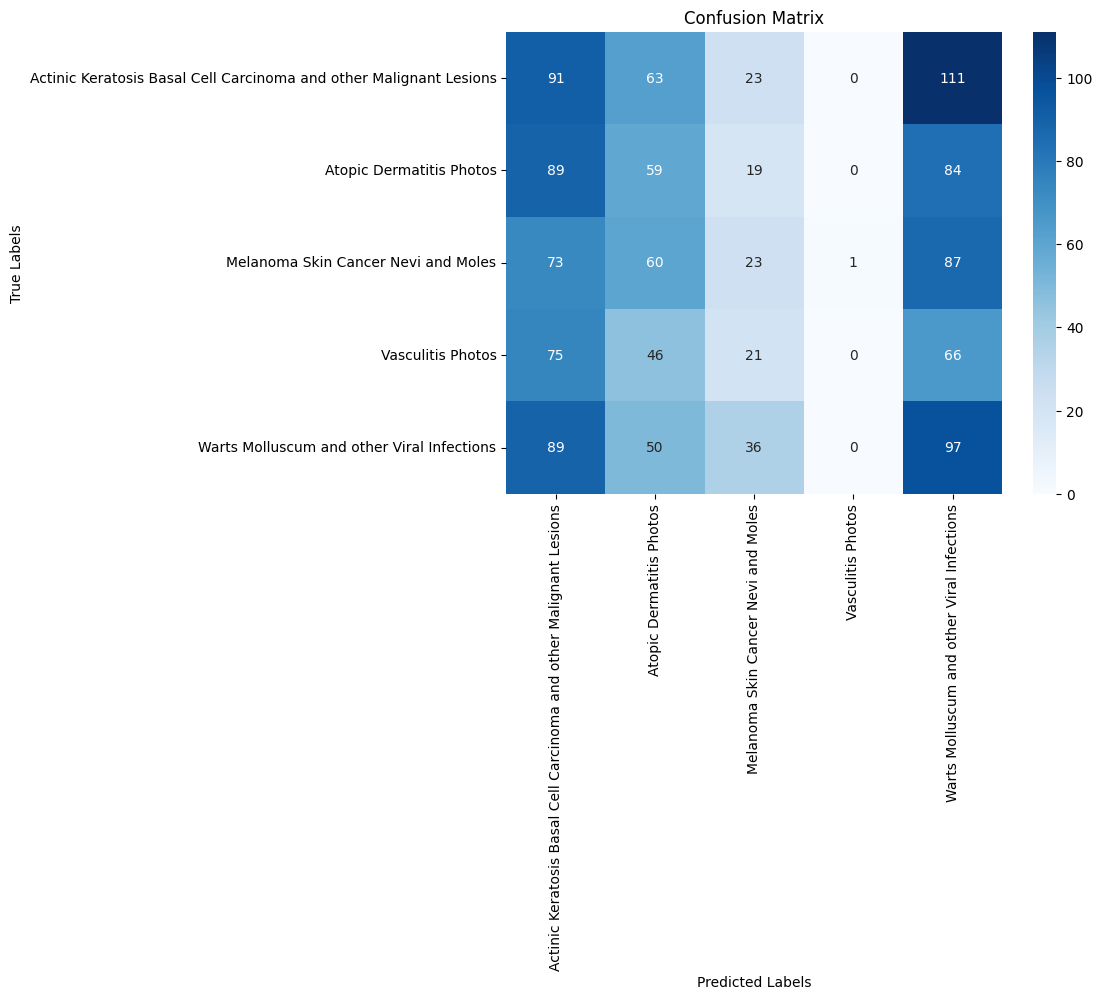

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()